# Set up example code

## Model setup

In [1]:
import subprocess

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy.linalg import lapack
from scipy import stats
import emcee
import numpy as np

import importlib

import os
import pickle
from pathlib import Path

import src.reader as Reader

## Step 1: prepare input pickle file

### Load stuff from text files

In [2]:
# Read data files
RawData1 = Reader.ReadData('input/Example/Data_PHENIX_AuAu200_RAACharged_0to10_2013.dat')
RawData2 = Reader.ReadData('input/Example/Data_PHENIX_AuAu200_RAACharged_40to50_2013.dat')
RawData3 = Reader.ReadData('input/Example/Data_ATLAS_PbPb2760_RAACharged_0to5_2015.dat')
RawData4 = Reader.ReadData('input/Example/Data_ATLAS_PbPb2760_RAACharged_30to40_2015.dat')
RawData5 = Reader.ReadData('input/Example/Data_CMS_PbPb5020_RAACharged_0to10_2017.dat')
RawData6 = Reader.ReadData('input/Example/Data_CMS_PbPb5020_RAACharged_30to50_2017.dat')

# Read covariance
# RawCov1 = Reader.ReadCovariance('input/Example/Covariance_PHENIX_AuAu200_RAACharged_0to10_2013_PHENIX_AuAu200_RAACharged_0to10_2013_SmallL.dat')
# RawCov2 = Reader.ReadCovariance('input/Example/Covariance_PHENIX_AuAu200_RAACharged_40to50_2013_PHENIX_AuAu200_RAACharged_40to50_2013_SmallL.dat')
# RawCov3 = Reader.ReadCovariance('input/Example/Covariance_ATLAS_PbPb2760_RAACharged_0to5_2015_ATLAS_PbPb2760_RAACharged_0to5_2015_SmallL.dat')
# RawCov4 = Reader.ReadCovariance('input/Example/Covariance_ATLAS_PbPb2760_RAACharged_30to40_2015_ATLAS_PbPb2760_RAACharged_30to40_2015_SmallL.dat')
# RawCov5 = Reader.ReadCovariance('input/Example/Covariance_CMS_PbPb5020_RAACharged_0to10_2017_CMS_PbPb5020_RAACharged_0to10_2017_SmallL.dat')
# RawCov6 = Reader.ReadCovariance('input/Example/Covariance_CMS_PbPb5020_RAACharged_30to50_2017_CMS_PbPb5020_RAACharged_30to50_2017_SmallL.dat')

# Read design points
RawDesign = Reader.ReadDesign('input/Example/Design.dat')

# Read model prediction
RawPrediction1 = Reader.ReadPrediction('input/Example/Prediction_PHENIX_AuAu200_RAACharged_0to10_2013.dat')
RawPrediction2 = Reader.ReadPrediction('input/Example/Prediction_PHENIX_AuAu200_RAACharged_40to50_2013.dat')
RawPrediction3 = Reader.ReadPrediction('input/Example/Prediction_ATLAS_PbPb2760_RAACharged_0to5_2015.dat')
RawPrediction4 = Reader.ReadPrediction('input/Example/Prediction_ATLAS_PbPb2760_RAACharged_30to40_2015.dat')
RawPrediction5 = Reader.ReadPrediction('input/Example/Prediction_CMS_PbPb5020_RAACharged_0to10_2017.dat')
RawPrediction6 = Reader.ReadPrediction('input/Example/Prediction_CMS_PbPb5020_RAACharged_30to50_2017.dat')

### Run this block for RHIC + LHC

In [3]:
# Initialize empty dictionary
AllData = {}

# Basic information
AllData["systems"] = ["AuAu200", "PbPb2760", "PbPb5020"]
AllData["keys"] = RawDesign["Parameter"]
AllData["labels"] = RawDesign["Parameter"]
AllData["ranges"] = [(0, 1.5), (0, 1.0), (0, 20), (0, 20), (1, 4)]
AllData["observables"] = [('R_AA', ['C0', 'C1'])]

# Data points
Data = {"AuAu200": {"R_AA": {"C0": RawData1["Data"], "C1": RawData2["Data"]}},
    "PbPb2760": {"R_AA": {"C0": RawData3["Data"], "C1": RawData4["Data"]}},
    "PbPb5020": {"R_AA": {"C0": RawData5["Data"], "C1": RawData6["Data"]}}}

# Model predictions
Prediction = {"AuAu200": {"R_AA": {"C0": {"Y": RawPrediction1["Prediction"], "x": RawData1["Data"]['x']},
                                   "C1": {"Y": RawPrediction2["Prediction"], "x": RawData2["Data"]['x']}}},
             "PbPb2760": {"R_AA": {"C0": {"Y": RawPrediction3["Prediction"], "x": RawData3["Data"]['x']},
                                   "C1": {"Y": RawPrediction4["Prediction"], "x": RawData4["Data"]['x']}}},
             "PbPb5020": {"R_AA": {"C0": {"Y": RawPrediction5["Prediction"], "x": RawData5["Data"]['x']},
                                   "C1": {"Y": RawPrediction6["Prediction"], "x": RawData6["Data"]['x']}}}}

# Covariance matrices - the indices are [system][measurement1][measurement2], each one is a block of matrix
Covariance = Reader.InitializeCovariance(Data)
Covariance["AuAu200"][("R_AA", "C0")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData1, RawData1, SysLength = {"default": 0.05})
Covariance["AuAu200"][("R_AA", "C1")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData2, RawData2, SysLength = {"default": 0.10})
Covariance["PbPb2760"][("R_AA", "C0")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData3, RawData3, SysLength = {"default": 0.15})
Covariance["PbPb2760"][("R_AA", "C1")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData4, RawData4, SysLength = {"default": 0.20})
Covariance["PbPb5020"][("R_AA", "C0")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData5, RawData5, SysLength = {"default": 0.25})
Covariance["PbPb5020"][("R_AA", "C1")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData6, RawData6, SysLength = {"default": 0.30})

# This is how we can add off-diagonal matrices
# Covariance["PbPb5020"][("R_AA", "C0")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData5, RawData6, SysLength = {"default": 100}, SysStrength = {"default": 0.1})
# Covariance["PbPb5020"][("R_AA", "C1")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData6, RawData5, SysLength = {"default": 100}, SysStrength = {"default": 0.1})

# This is how we can supply external pre-generated matrices
# Covariance["AuAu200"][("R_AA", "C0")][("R_AA", "C0")] = RawCov1["Matrix"]


# Assign data to the dictionary
AllData["design"] = RawDesign["Design"]
AllData["model"] = Prediction
AllData["data"] = Data
AllData["cov"] = Covariance

# Save to the desired pickle fileglobal picklefile
picklefile = 'input/example.p'
with open(picklefile, 'wb') as handle:
    pickle.dump(AllData, handle, protocol = pickle.HIGHEST_PROTOCOL)

Reader.Initialize(picklefile)

### Optional: clean past files

In [4]:
# Clean past MCMC samples
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")

# Clean past emulator
for system in AllData["systems"]:
    if os.path.exists('cache/emulator/' + system + ".pkl"):
        os.remove('cache/emulator/' + system + ".pkl")

## Step 2: run emulator

In [5]:
! python3 -m src.emulator --retrain --npc 10

In [6]:
from src import lazydict, emulator
EmulatorAuAu200 = emulator.Emulator.from_cache('AuAu200')
EmulatorPbPb2760 = emulator.Emulator.from_cache('PbPb2760')
EmulatorPbPb5020 = emulator.Emulator.from_cache('PbPb5020')

[INFO][emulator] training emulator for system AuAu200 (10 PC, 0 restarts)
[ 1.5  1.  20.  20.   3. ]


/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 4 of parameter k2__length_scale is close to the specified upper bound 30.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 200.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/

[INFO][emulator] writing cache file cache/emulator/AuAu200.pkl
[INFO][emulator] training emulator for system PbPb2760 (10 PC, 0 restarts)


/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 4 of parameter k2__length_scale is close to the specified lower bound 0.30000000000000004. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified lower bound 2.0. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarnin

[ 1.5  1.  20.  20.   3. ]


/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 200.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 4 of parameter k2__length_scale is close to the specified upper bound 30.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 200.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch

[INFO][emulator] writing cache file cache/emulator/PbPb2760.pkl
[INFO][emulator] training emulator for system PbPb5020 (10 PC, 0 restarts)


/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 200.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 4 of parameter k2__length_scale is close to the specified lower bound 0.30000000000000004. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWar

[ 1.5  1.  20.  20.   3. ]


/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified lower bound 2.0. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 4 of parameter k2__length_scale is close to the specified lower bound 0.30000000000000004. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarni

[INFO][emulator] writing cache file cache/emulator/PbPb5020.pkl


/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 200.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.15000000000000002. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarn

## Step 3: MCMC sampling

In [7]:
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")
! python3 -m src.mcmc --nwalkers 500 --nburnsteps 500 1500  --picklefile $picklefile

[INFO][mcmc] no existing chain found, starting initial burn-in
[INFO][mcmc] running 500 walkers for 250 steps
[INFO][mcmc] step 25: acceptance fraction: mean 0.3137, std 0.1330, min 0.0000, max 0.6400
[INFO][mcmc] step 50: acceptance fraction: mean 0.2970, std 0.1082, min 0.0000, max 0.5600
[INFO][mcmc] step 75: acceptance fraction: mean 0.2900, std 0.0958, min 0.0000, max 0.5467
[INFO][mcmc] step 100: acceptance fraction: mean 0.2939, std 0.0894, min 0.0000, max 0.5100
[INFO][mcmc] step 125: acceptance fraction: mean 0.2986, std 0.0869, min 0.0000, max 0.5200
[INFO][mcmc] step 150: acceptance fraction: mean 0.3067, std 0.0866, min 0.0000, max 0.5467
[INFO][mcmc] step 175: acceptance fraction: mean 0.3132, std 0.0868, min 0.0057, max 0.5029
[INFO][mcmc] step 200: acceptance fraction: mean 0.3199, std 0.0865, min 0.0050, max 0.5200
[INFO][mcmc] step 225: acceptance fraction: mean 0.3253, std 0.0858, min 0.0044, max 0.5200
[INFO][mcmc] step 250: acceptance fraction: mean 0.3300, std 0.08

## Step 4: Analyze posterior samples

In [8]:
import src
src.Initialize()
from src import mcmc
chain = mcmc.Chain(picklefile=picklefile)
MCMCSamples = chain.load()

TransformedSamples = np.copy(MCMCSamples)
TransformedSamples[:,0] = MCMCSamples[:,0] * MCMCSamples[:,1]
TransformedSamples[:,1] = MCMCSamples[:,0] - MCMCSamples[:,0] * MCMCSamples[:,1]
TransformedSamples[:,2] = MCMCSamples[:,2]
TransformedSamples[:,3] = MCMCSamples[:,3]
TransformedSamples[:,4] = MCMCSamples[:,4]

In [9]:
! python3 -m src.plots posterior gp diag_emu --picklefile $picklefile

[INFO][plots] Default system: AuAu200
[INFO][plots] generating plot: posterior
/scratch/user/cameron.parker/newJETSCAPE/stattest/STAT/src/plots.py:860: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  cmap.set_bad('white')
[WARNING][font_manager] findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
[INFO][plots] wrote plots/posterior.pdf
[INFO][plots] Default system: AuAu200
[INFO][plots] generating plot: gp
[INFO][plots] wrote plots/gp.pdf
[INFO][plots] Default system: AuAu200
[INFO][plots] generating plot: diag_emu
[INFO][plots] wrote plots/diag_emu.pdf


## Step 5: adding all sorts of plots

/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


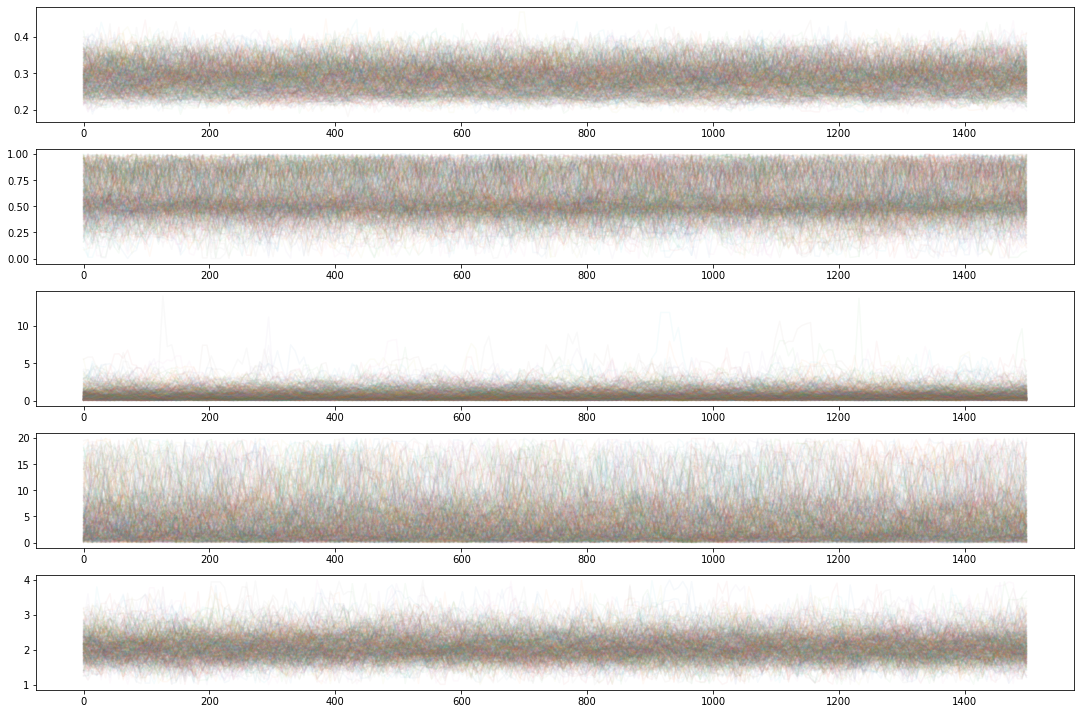

In [10]:
with chain.dataset() as d:
    W = d.shape[0]     # number of walkers
    S = d.shape[1]     # number of steps
    N = d.shape[2]     # number of paramters
    T = int(S / 200)   # "thinning"
    A = 20 / W
    figure, axes = plt.subplots(figsize = (15, 2 * N), ncols = 1, nrows = N)
    for i, ax in enumerate(axes):
        for j in range(0, W):
            ax.plot(range(0, S, T), d[j, ::T, i], alpha = A)
    plt.tight_layout(True)
    plt.savefig('plots/MCMCSamples.pdf', dpi = 192)

/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


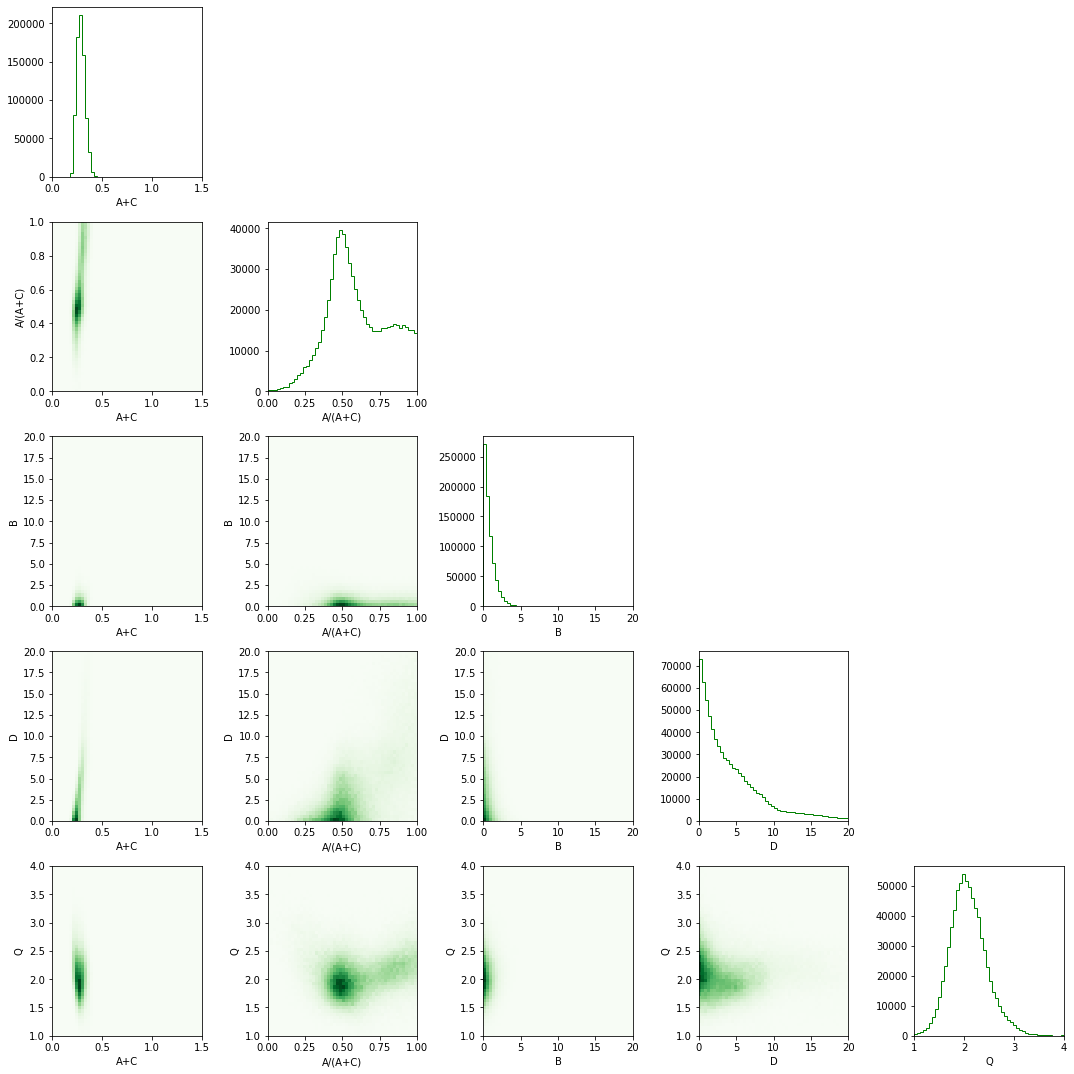

In [11]:
NDimension = len(AllData["labels"])
Ranges = np.array(AllData["ranges"]).T
figure, axes = plt.subplots(figsize = (3 * NDimension, 3 * NDimension), ncols = NDimension, nrows = NDimension)
Names = AllData["labels"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(MCMCSamples[:,i], bins=50,
                    range=Ranges[:,i], histtype='step', color='green')
            ax.set_xlabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
        if i>j:
            ax.hist2d(MCMCSamples[:, j], MCMCSamples[:, i], 
                      bins=50, range=[Ranges[:,j], Ranges[:,i]], 
                      cmap='Greens')
            ax.set_xlabel(Names[j])
            ax.set_ylabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
            ax.set_ylim(*Ranges[:,i])
        if i<j:
            ax.axis('off')
plt.tight_layout(True)
plt.savefig('plots/Correlation.pdf', dpi = 192)
# figure

/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


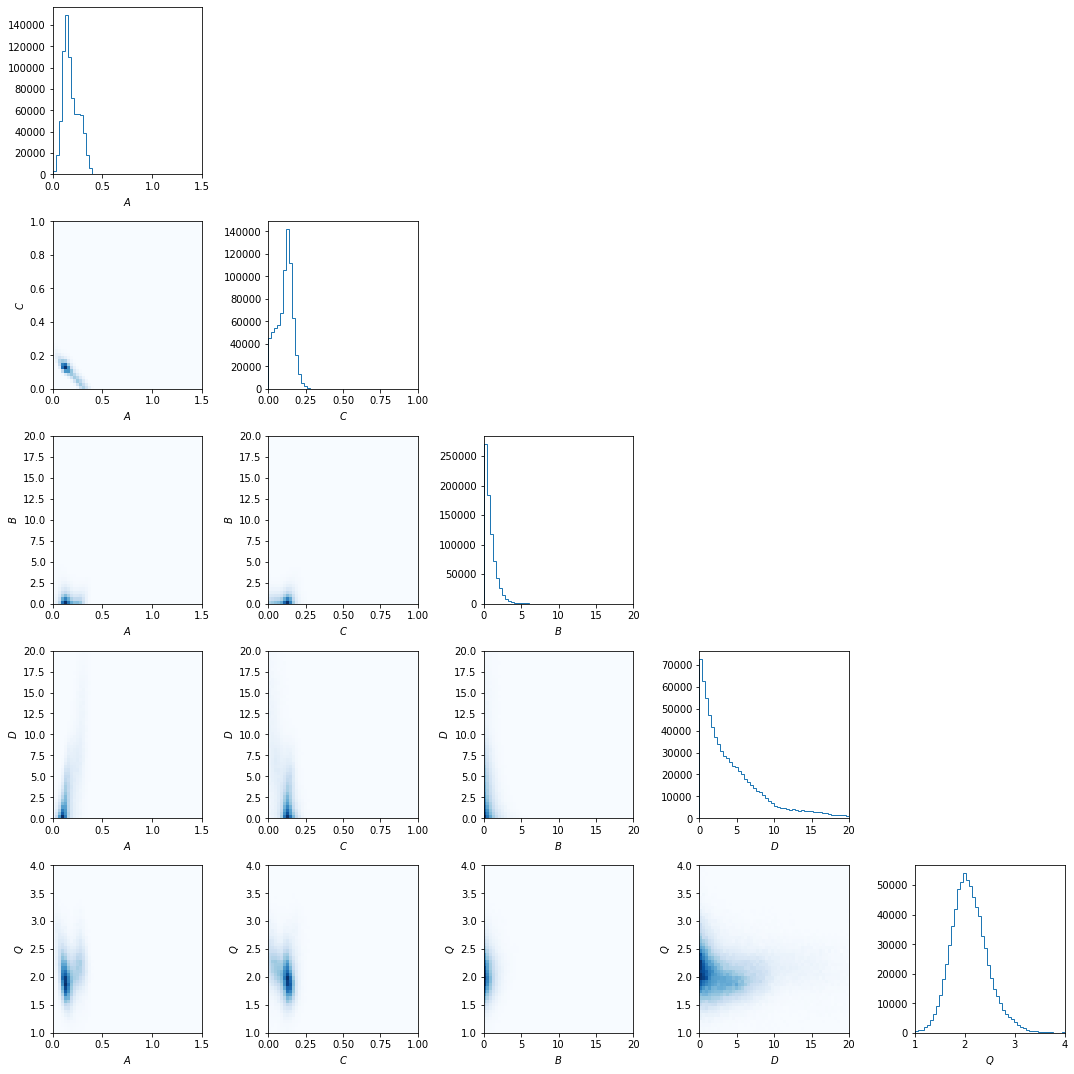

In [12]:
NDimension = 5
Ranges = np.array(AllData["ranges"]).T
figure, axes = plt.subplots(figsize = (15, 15), ncols = NDimension, nrows = NDimension)
Names = [r"$A$", r"$C$", r"$B$", r"$D$", r"$Q$", r"$P_6$"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(TransformedSamples[:,i], bins=50,
                    range=Ranges[:,i], histtype='step')
            ax.set_xlabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
        if i>j:
            ax.hist2d(TransformedSamples[:, j], TransformedSamples[:, i], 
                      bins=50, range=[Ranges[:,j], Ranges[:,i]], 
                      cmap='Blues')
            ax.set_xlabel(Names[j])
            ax.set_ylabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
            ax.set_ylim(*Ranges[:,i])
        if i<j:
            ax.axis('off')
plt.tight_layout(True)
plt.savefig('plots/TransformedCorrelation.pdf', dpi = 192)
# figure

/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


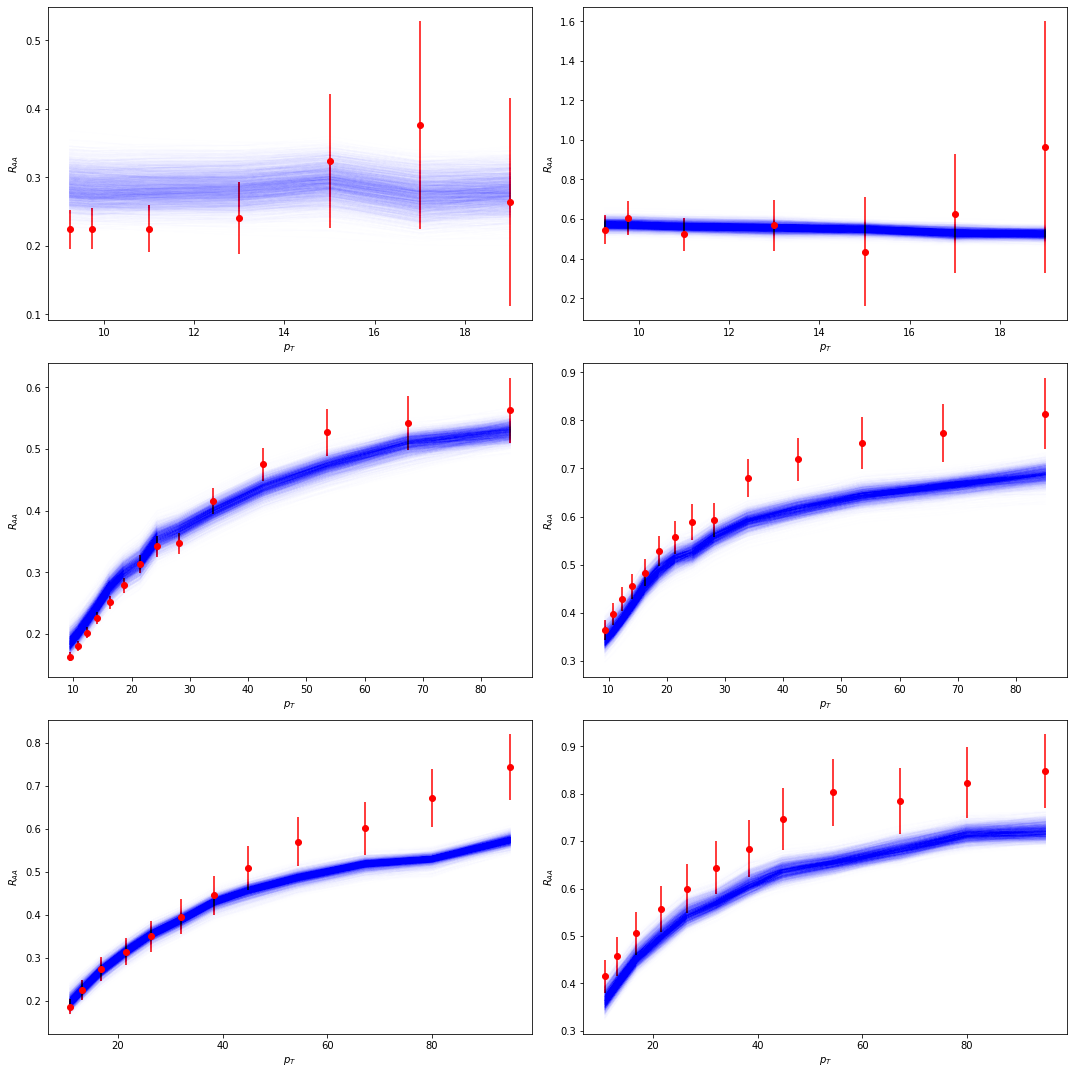

In [13]:
Examples = MCMCSamples[ np.random.choice(range(len(MCMCSamples)), 2500), :]

TempPrediction = {"AuAu200": EmulatorAuAu200.predict(Examples),
                 "PbPb2760": EmulatorPbPb2760.predict(Examples),
                 "PbPb5020": EmulatorPbPb5020.predict(Examples)}

SystemCount = len(AllData["systems"])

figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = SystemCount)

for s1 in range(0, SystemCount):
    for s2 in range(0, 2):
        axes[s1][s2].set_xlabel(r"$p_{T}$")
        axes[s1][s2].set_ylabel(r"$R_{AA}$")
        
        S1 = AllData["systems"][s1]
        O  = AllData["observables"][0][0]
        S2 = AllData["observables"][0][1][s2]
        
        DX = AllData["data"][S1][O][S2]['x']
        DY = AllData["data"][S1][O][S2]['y']
        DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
        for i, y in enumerate(TempPrediction[S1][O][S2]):
            axes[s1][s2].plot(DX, y, 'b-', alpha=0.005, label="Posterior" if i==0 else '')
        axes[s1][s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

plt.tight_layout(True)
figure.savefig('plots/ObservablePosterior.pdf', dpi = 192)
# figure

/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


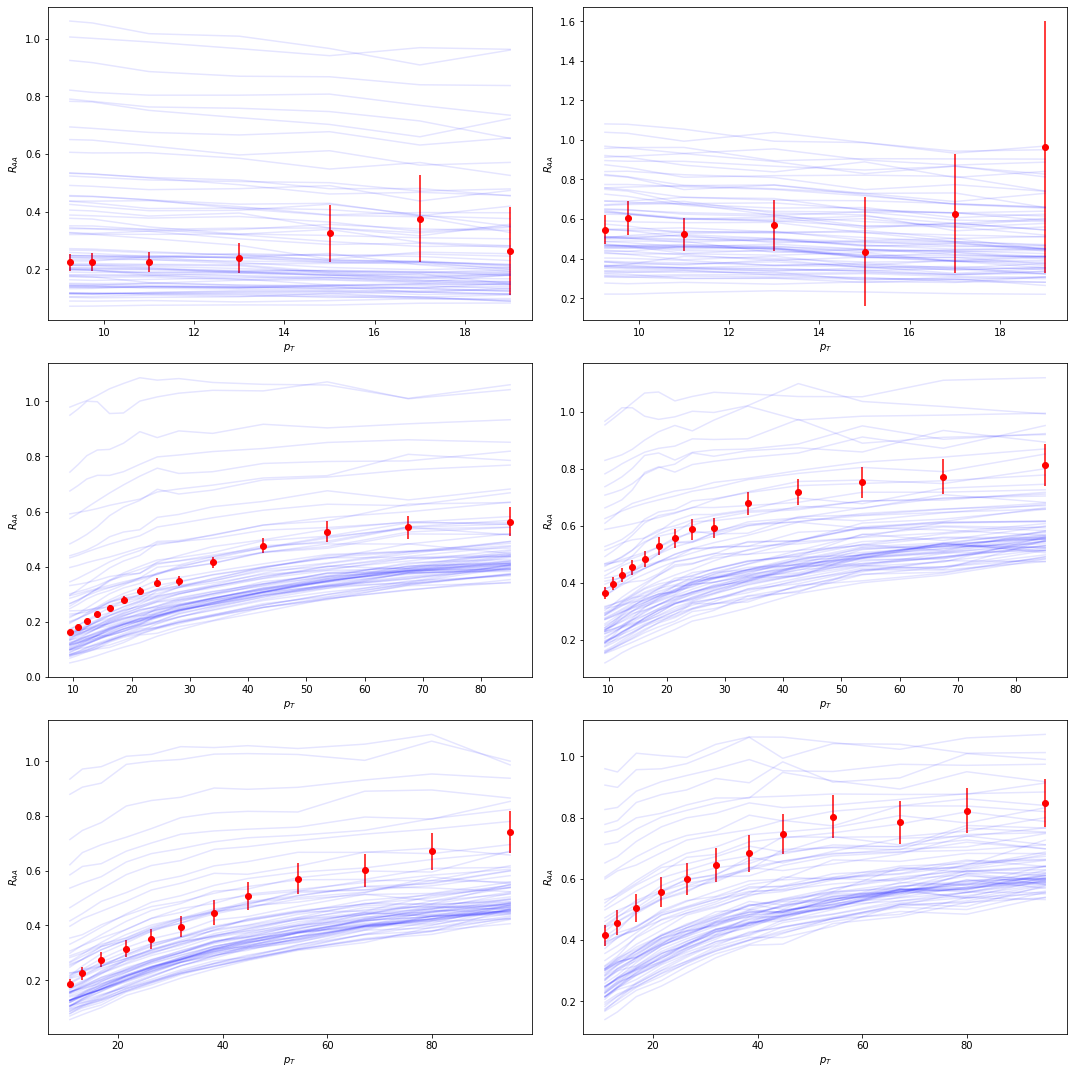

In [14]:
Examples = AllData["design"]

TempPrediction = {"AuAu200": EmulatorAuAu200.predict(Examples),
                 "PbPb2760": EmulatorPbPb2760.predict(Examples),
                 "PbPb5020": EmulatorPbPb5020.predict(Examples)}

SystemCount = len(AllData["systems"])

figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = SystemCount)

for s1 in range(0, SystemCount):
    for s2 in range(0, 2):
        axes[s1][s2].set_xlabel(r"$p_{T}$")
        axes[s1][s2].set_ylabel(r"$R_{AA}$")
        
        S1 = AllData["systems"][s1]
        O  = AllData["observables"][0][0]
        S2 = AllData["observables"][0][1][s2]
        
        DX = AllData["data"][S1][O][S2]['x']
        DY = AllData["data"][S1][O][S2]['y']
        DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
        for i, y in enumerate(TempPrediction[S1][O][S2]):
            axes[s1][s2].plot(DX, y, 'b-', alpha=0.1, label="Posterior" if i==0 else '')
        axes[s1][s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

plt.tight_layout(True)
figure.savefig('plots/PredictedDesign.pdf', dpi = 192)
# figure

/scratch/user/cameron.parker/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


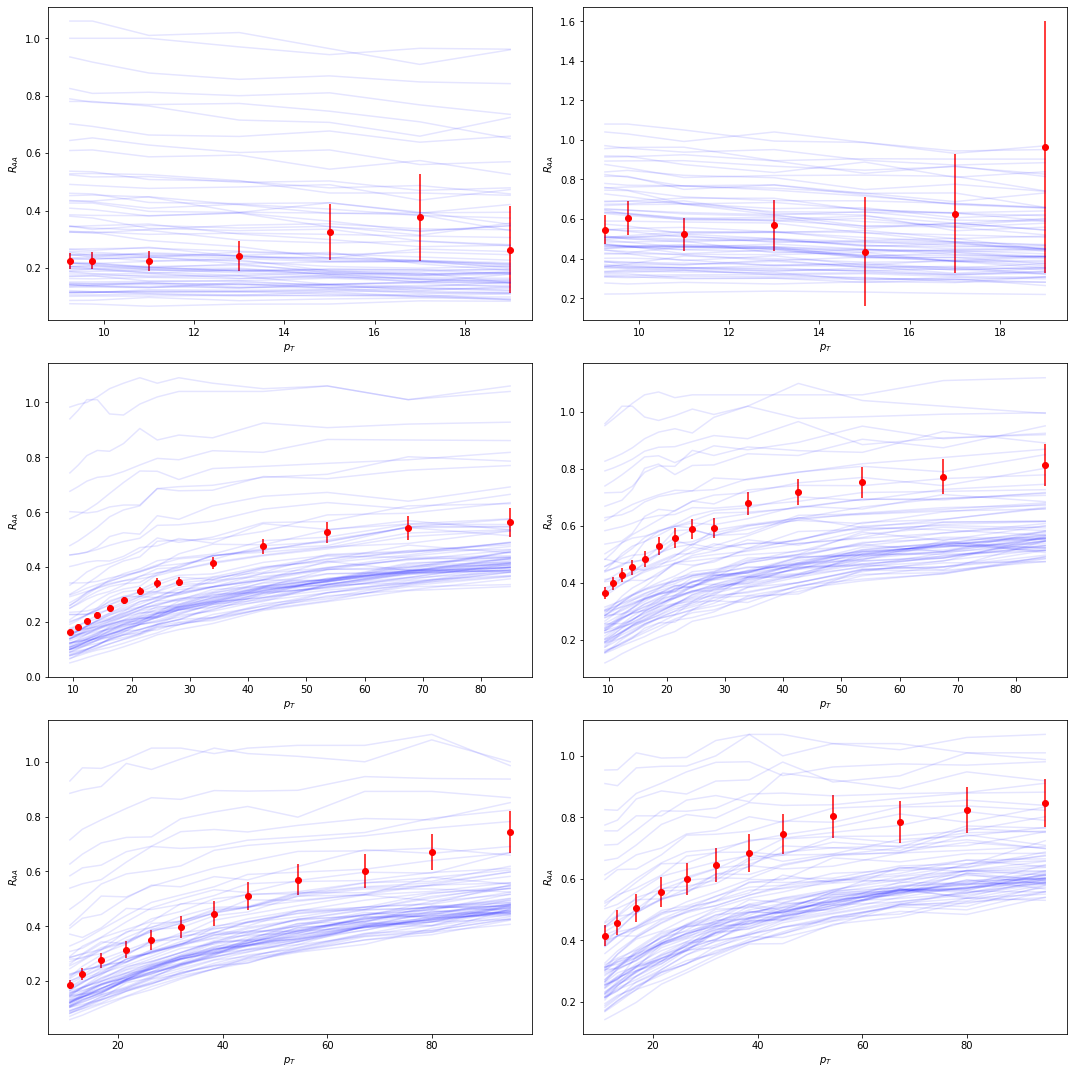

In [15]:
TempPrediction = AllData["model"]

SystemCount = len(AllData["systems"])

figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = SystemCount)

for s1 in range(0, SystemCount):
    for s2 in range(0, 2):
        axes[s1][s2].set_xlabel(r"$p_{T}$")
        axes[s1][s2].set_ylabel(r"$R_{AA}$")
        
        S1 = AllData["systems"][s1]
        O  = AllData["observables"][0][0]
        S2 = AllData["observables"][0][1][s2]
        
        DX = AllData["data"][S1][O][S2]['x']
        DY = AllData["data"][S1][O][S2]['y']
        DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
        for i, y in enumerate(TempPrediction[S1][O][S2]['Y']):
            axes[s1][s2].plot(DX, y, 'b-', alpha=0.1, label="Posterior" if i==0 else '')
        axes[s1][s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

plt.tight_layout(True)
figure.savefig('plots/Design.pdf', dpi = 192)
# figure

In [16]:
# close all plots to save memory
plt.close('all')